In [35]:
%load_ext autoreload
%autoreload 2

import torch

from tqdm import tqdm

from src.deep_ad.config import Config
from src.deep_ad.data.dagm_dataset import DAGMDataset
from src.deep_ad.eval import load_pretrained, pad_image
from src.deep_ad.image import plot_images, create_center_mask
from src.deep_ad.save_manager import SaveManager
from src.deep_ad.transforms import create_test_transform, normalize_to_mean_std

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# Load configuration and save manager
config = Config(root_dir="..", config_path="../default_config.yml")
config.content_size = 24
config.stride = 16
save_manager = SaveManager(config)

Load pretrained model


In [37]:
run_name = "13-e_class_10_10_batch"
checkpoint_name = "epoch_200"
model = load_pretrained(config, save_manager, run_name, checkpoint_name)
model = model.to(config.device)

Checkpoint loaded from '..\save\checkpoints\13-e_class_10_10_batch\epoch_200.pt'.


Load the test dataset


In [38]:
test_transform = create_test_transform()
test_dataset = DAGMDataset(
    img_dir=config.DAGM_raw_dir,
    transform=test_transform,
    target_transform=test_transform,
    classes=[10],
    type="Defect-only",
    train=False,
)

Load image(s)


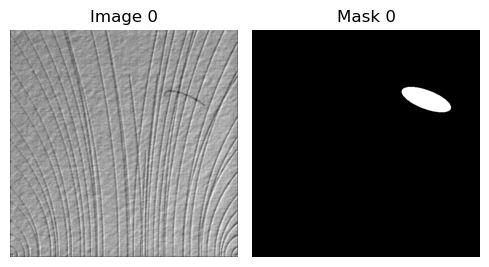

In [40]:
%matplotlib inline
idx = 0
image, mask = test_dataset[idx]
image, mask = image.squeeze(), mask.squeeze()
titles = [f"Image {idx}", f"Mask {idx}"]
plot_images([image, mask], titles, rows=1, cols=2)

Notations:

$$
\begin{align*}
L &:=\text{image size} &=512\\
l &:=\text{patch size} &=128\\
c &:=\text{center size} &=32\\
c' &:=\text{content size} &=24\\
s &:=\text{stride} &=16\\
mp &:=\text{minimum padding} &=52\\
m &:=\text{margin} &=8\\
p &:=\text{total padding} &=60\\
\end{align*}
$$

In order to compute how much padding we need to add to each image, we must take into account several considerations.

In the first place, we want the first patch to have its content region (the center $24\times24$ region) placed on the top-leftmost pixel of the original, unpadded image. Thus, we have a _minimum padding_ ($mp$), which will be the required padding to add for the first patch to be able to reside with their center $24\times24$ regions on the $(0, 0)$ coordinates of the original image:
$$mp = \frac{l - c'}{2}$$

Second, if we slide a $24\times24$ window with stride $16$ over the original image, the last patch might require an additional margin because it won't fit. Let's call this margin $m$:
$$m = (s - ((L - c')\mod s))\mod s$$

Lastly, the total padding required, $p$, will be the sum of the minimum padding and the margin:
$$p=mp+m$$


Minimum required padding: 52
Additional margin: 8
Total padding: 60
Padded image shape: torch.Size([632, 632])


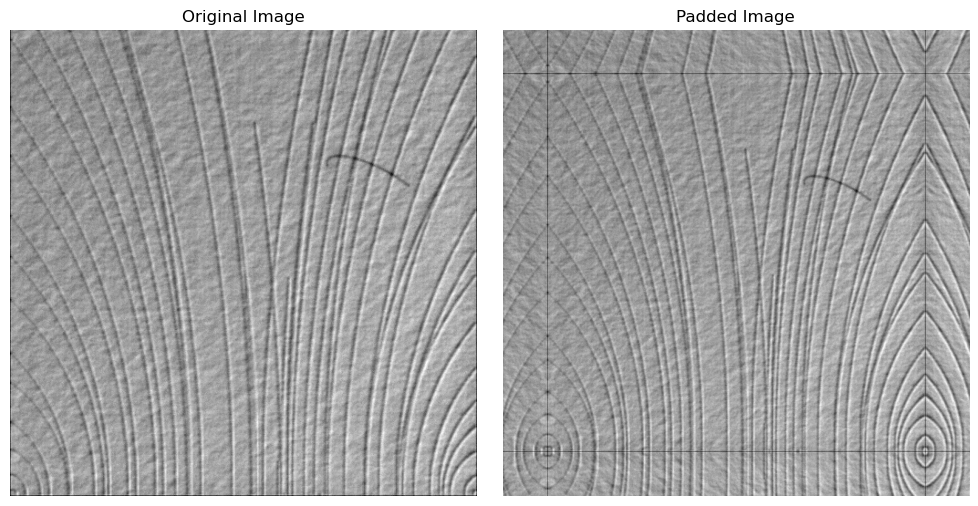

In [43]:
padded_image, min_pad, margin, pad_size = pad_image(config, image.unsqueeze(0))
print(f"Minimum required padding: {min_pad}")
print(f"Additional margin: {margin}")
print(f"Total padding: {pad_size}")
print(f"Padded image shape: {padded_image.shape}")
plot_images([image, padded_image], ["Original Image", "Padded Image"], rows=1, cols=2, figsize=(10, 5))

In [18]:
image_length = image.shape[-1]
num_windows = (image_length + 2 * pad_size - config.patch_size) // config.stride + 1
print(f"Number of windows: {num_windows}")
num_windows = int(num_windows)

Number of windows: 32


In [25]:
import cv2 as cv


patches = []
inputs = []
outputs = []
titles = []
inpainted_contents = []
mask = torch.asarray(create_center_mask(image_size=config.patch_size, center_size=config.center_size))
with tqdm(total=num_windows**2, desc="Patches processed", unit="patch") as pbar:
    for i in range(num_windows):
        for j in range(num_windows):
            tli, bri = margin + i * config.stride, margin + i * config.stride + config.patch_size # top-left
            tlj, brj = margin + j * config.stride, margin + j * config.stride + config.patch_size # bottom-right
            patch = padded_image[tli : bri, tlj : brj]
            # print(
            #     f"({i:2d}, {j:2d}): top-left: ({tli}, {tlj}), bottom-right: ({bri:3d}, {brj:3d}), shape: {patch.shape}"
            # )

            input = normalize_to_mean_std(patch.unsqueeze(0).unsqueeze(0), mean=0.5267019737681685, std=0.19957033073362934)
            input = input * (1 - mask)
            input = input.to(config.device)
            output = model(input)
            output = normalize_to_mean_std(output, mean=image.mean(), std=image.std())
            tl, br = (config.patch_size - config.content_size) // 2, (config.patch_size + config.content_size) // 2
            inpainted_contents.append(output.detach().squeeze().cpu().numpy()[tl:br, tl:br])
            outputs.append(output.detach().squeeze().cpu().numpy())

            if i >= 12 and i < 16 and j >= 24 and j < 32:
                # Add a red square over the content region (center 24x24):
                patch_rgb = cv.cvtColor(patch.numpy(), cv.COLOR_GRAY2RGB)
                cv.rectangle(patch_rgb, (52 - 1, 52 - 1), (76 + 1, 76 + 1), (255, 0, 0), 1)
                patches.append(patch_rgb)
                inputs.append(input.detach().squeeze().cpu().numpy())
                titles.append(f"r{i}c{j}")
            pbar.update(1)

    # plot_images(patches, titles, rows=4, cols=4)
    # plot_images(inputs, titles, rows=4, cols=4)
    # plot_images(outputs, titles, rows=4, cols=4)

Patches processed: 100%|██████████| 1024/1024 [00:07<00:00, 131.29patch/s]


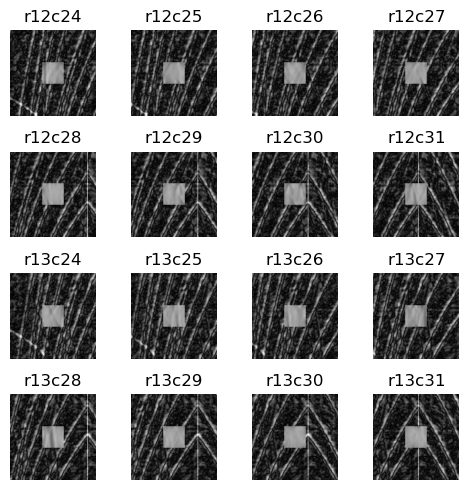

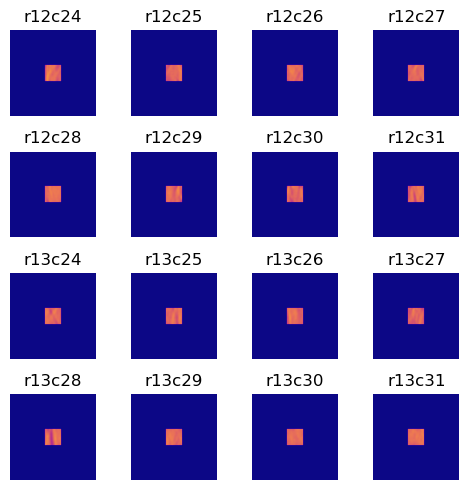

In [26]:
%matplotlib inline
diffs = [torch.abs(torch.asarray(input) - torch.asarray(output)) for input, output in zip(inputs, outputs)]
content_mask = create_center_mask(128, 24)
contents = [diff * content_mask for diff in diffs]
# plot_images(outputs, titles, rows=4, cols=4)
plot_images(diffs, titles, rows=4, cols=4)
plot_images(contents, titles, rows=4, cols=4, cmap="plasma", range="01")

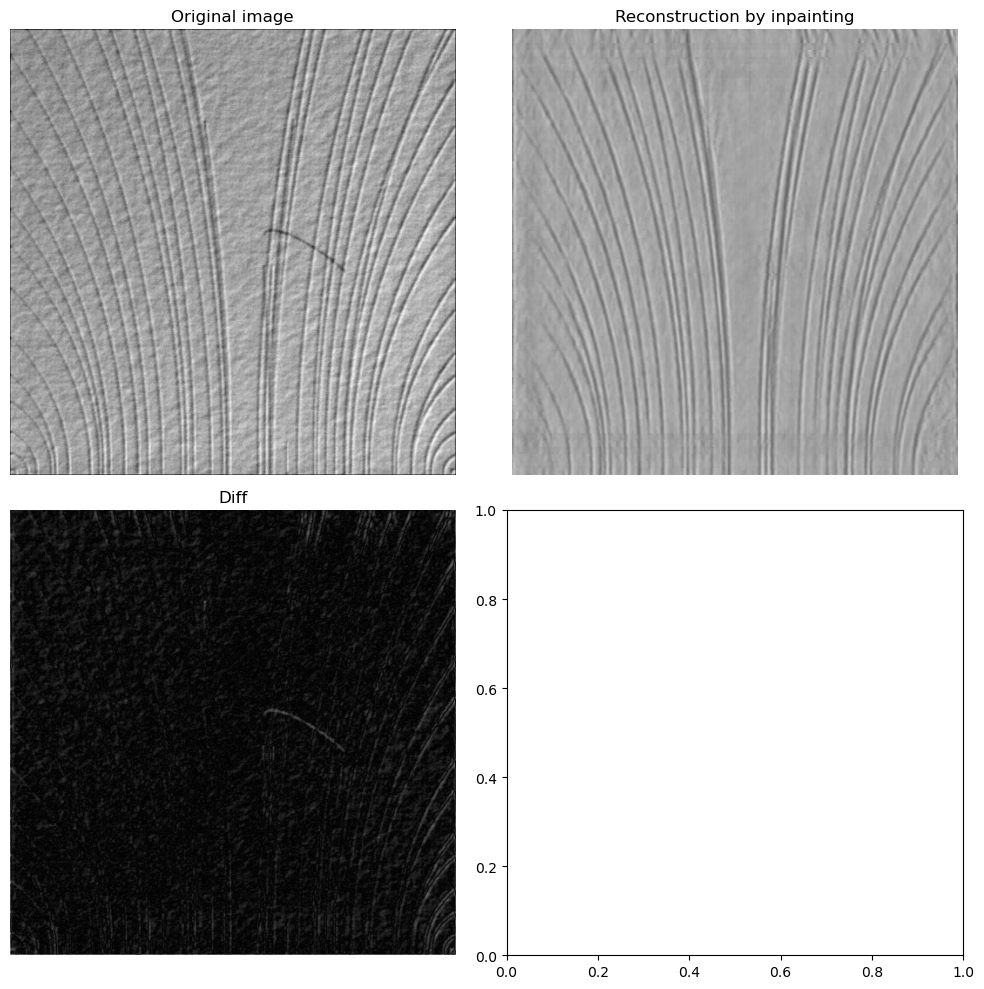

In [27]:
image_size = image.shape[-1]
inpainted_image = torch.zeros((image_size + margin, image_size + margin))
weights = torch.zeros((image_size + margin, image_size + margin))
for i in range(num_windows):
    for j in range(num_windows):
        tli, bri = i * config.stride, i * config.stride + config.content_size
        tlj, brj = j * config.stride, j * config.stride + config.content_size
        inpainted_image[tli:bri, tlj:brj] += torch.asarray(inpainted_contents[i * num_windows + j])
        weights[tli:bri, tlj:brj] += 1
inpainted_image /= weights
inpainted_image = inpainted_image[:image_size, :image_size]
diff_image = torch.abs(image - inpainted_image)
plot_images(
    [image, inpainted_image, diff_image],
    ["Original image", "Reconstruction by inpainting", "Diff"],
    rows=2,
    cols=2,
    figsize=(10, 10),
)

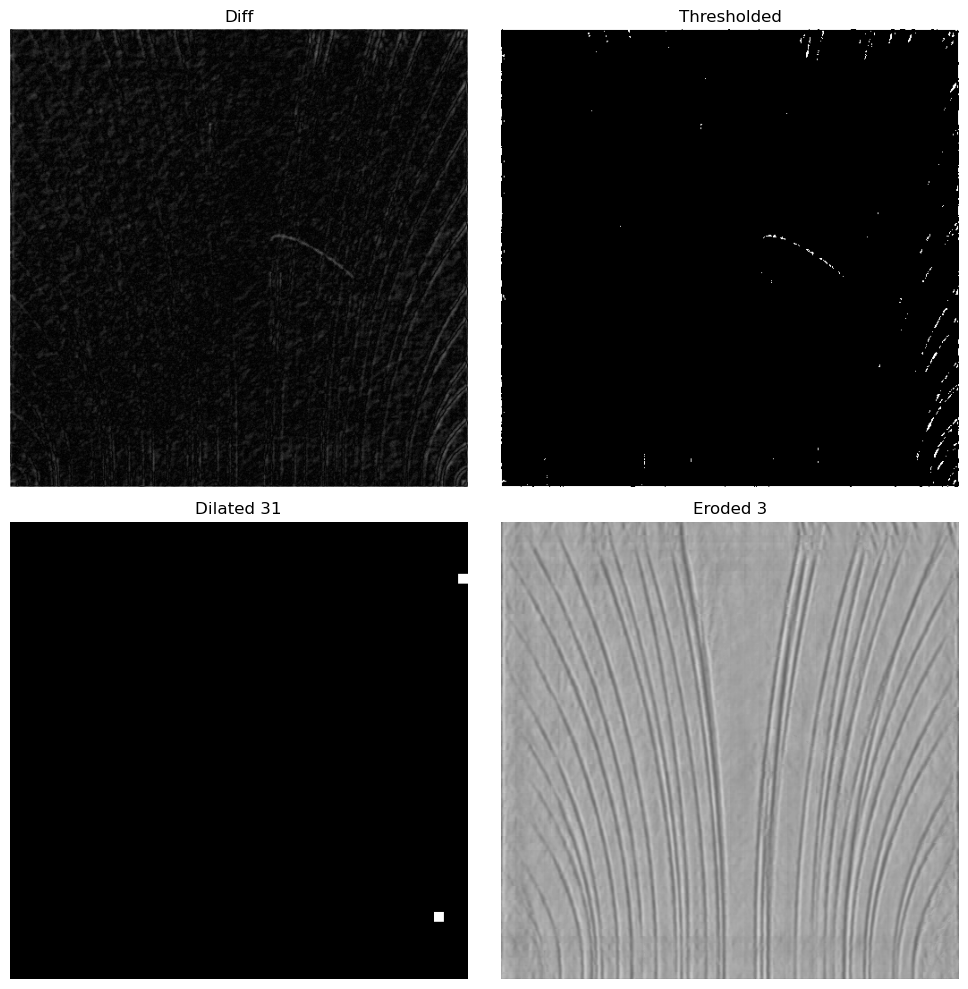

In [28]:
import cv2 as cv
import numpy as np

threshold = 0.25
thresholded_diff = diff_image.clone()
thresholded_diff[thresholded_diff < threshold] = 0
thresholded_diff[thresholded_diff >= threshold] = 1

eroded = thresholded_diff.numpy()
erode_k = 3
eroded = cv.erode(eroded, np.ones((erode_k, erode_k), np.uint8))
eroded = cv.dilate(eroded, np.ones((erode_k, erode_k), np.uint8))

dilated = eroded
dilate_k = 31
dilate_k2 = 23
dilated = cv.dilate(dilated, np.ones((dilate_k, dilate_k), np.uint8))
dilated = cv.erode(dilated, np.ones((dilate_k2, dilate_k2), np.uint8))

replaced = inpainted_image.clone()
alpha = 0.9
replaced[thresholded_diff > 0] = alpha * replaced[thresholded_diff > 0] + (1 - alpha) * image[thresholded_diff > 0]

plot_images([diff_image, thresholded_diff, dilated, replaced], ["Diff", "Thresholded", f"Dilated {dilate_k}", f"Eroded {erode_k}"], cmap="gray", rows=2, cols=2, figsize=(10, 10))